# Mobïus vs. Capacities for fitness functions comparison
In this notebook, we will compare the performance of Mobïus and Capacities for fitness functions. We will test on both dynamic positive gaussian data and `iris` dataset.

In [1]:
# Import basic libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import time
from sklearn.preprocessing import LabelEncoder
import os
os.chdir("/Users/hoangthuyduongvu/Desktop/FuzzSIM")


In [2]:
# Import personalized libraries
from fuzz.src.capacity import *
from fuzz.choquet.choquet import *
from fuzz.src.norm import *
from fuzz.src.knn import KNNFuzz
from fuzz.src.sim import S1, S2, S3
from fuzz.optim import *
from fuzz.utils import *
from fuzz.eval import leave_one_out
from fuzz.dataloader import *
from fuzz.choquet.d_choquet import *

## Dynamic Positive Gaussian Data

In [3]:
data, labels = dynamic_generate_positive_gaussian_data(
    dim=3,
    nb_classes=3,
    nb_points_per_class=50,
    seed=42
)
data = batch_norm(data)
data[:5]

array([[0.        , 1.        , 0.01959192],
       [1.        , 0.        , 0.4070175 ],
       [0.        , 0.38090406, 1.        ],
       [0.6965442 , 0.        , 1.        ],
       [0.        , 1.        , 0.99405304]])

In [4]:
# Generate all possible mobius for training
features = list(range(len(data[0])))    # encode features as integers

nb_total = 5

# Input Mobius (10 mobius currently)
lst_mobius = []
for i in range(nb_total):
    mobius = generate_mobius(features, 2)
    mobius.pop(0)
    lst_mobius.append(mobius)

# Mutate all mobius
mutated = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    mutated_mobius = mutate(mobius, mutation_rate=0.8)
    mutated.append(mutated_mobius)

# Add mutated mobius to the list
lst_mobius.extend(mutated)

# Cross over all mobius
crossed_over = []
for i in range(len(lst_mobius)):
    for j in range(i + 1, len(lst_mobius) // 2):
        crossed = crossover(lst_mobius[np.random.randint(len(lst_mobius))], lst_mobius[np.random.randint(len(lst_mobius))])
        crossed_over.append(crossed)

# Add crossed over mobius to the list
lst_mobius.extend(crossed_over)
print(f"Total number of Möbius measures: {len(lst_mobius)}")

# Convert all Möbius measures to capacities
capacities_list = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    capacity = mobius_to_capacity(mobius, features)
    capacities_list.append(capacity)    
print('Test Möbius measures completed!')
print(f"Total number of capacities: {len(capacities_list)}")

Total number of Möbius measures: 20
Test Möbius measures completed!
Total number of capacities: 20


### Test on Mobïus


In [5]:
# Define hyperparameters
p = np.arange(0.25, 3, 0.25)  # p values for Choquet integral
q = np.arange(0.25, 3, 0.25)  # q values for Choquet integral
sim = S2  # similarity measures
choquet_version = 'linear'
verbose = False 
eval_type = 'crossval'  # evaluation type
sim_agent = 'mobius'  # similarity agent for d_Choquet

# Define training loop
best_indexes = []
best_accuracies = []
best_mobius = []
print("Starting training loop...")
start_time = time.time()
i = 0
for p_val in p:
    for q_val in q:
        i += 1
        if i % 10 == 0:
            print(f"Progress: {i}/{len(p) * len(q)}")
        FF_res = fitness_function(
            capacities_list=lst_mobius,
            DS=(data, labels),
            sim=sim,
            choquet_version=choquet_version,
            p=p_val,
            q=q_val,
            time_counter=False,
            verbose=verbose,
            eval_type=eval_type,
            sim_agent=sim_agent
        )
        best_indexes.append(np.argmin(FF_res))
        best_accuracies.append(-FF_res[np.argmin(FF_res)])
        best_mobius.append(lst_mobius[np.argmin(FF_res)])

end_time = time.time()
print(f"Training loop completed in {end_time - start_time:.2f} seconds.")

Starting training loop...
Progress: 10/121
Progress: 20/121
Progress: 30/121
Progress: 40/121
Progress: 50/121
Progress: 60/121
Progress: 70/121
Progress: 80/121
Progress: 90/121
Progress: 100/121
Progress: 110/121
Progress: 120/121
Training loop completed in 549.23 seconds.


Best index: 24, Best accuracy: 0.5
Best Möbius measure: ['[0]: 0.976', '[1]: 0.608', '[2]: 0.752', '[0, 1]: 0.754', '[0, 2]: 0.500', '[1, 2]: 0.010']

Best Capacity:
Capacity of [] is 0.000
Capacity of [0] is 0.271
Capacity of [1] is 0.169
Capacity of [2] is 0.209
Capacity of [0, 1] is 0.650
Capacity of [0, 2] is 0.619
Capacity of [1, 2] is 0.380
Capacity of [0, 1, 2] is 1.000
Result in 0.9094 seconds.
Best accuracy: 0.3267


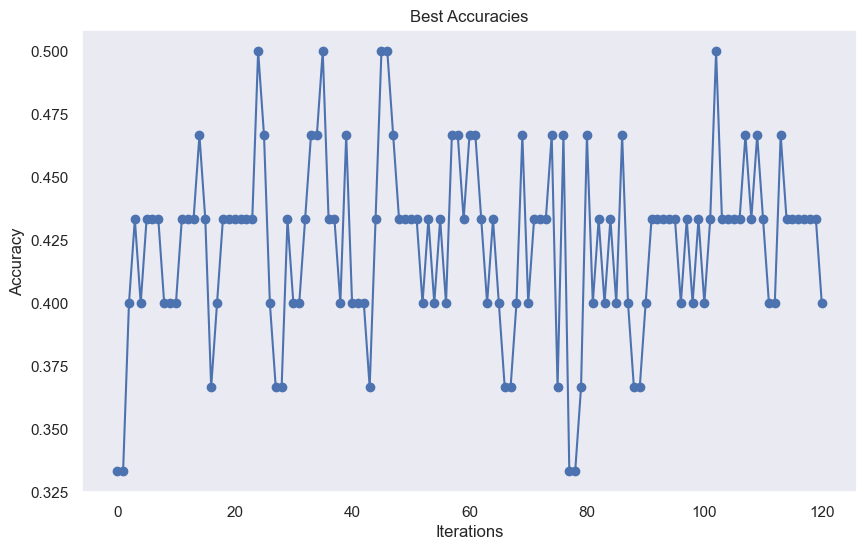

In [6]:
# Find the best index and accuracy
best_index = np.argmax(best_accuracies)
best_accuracy = best_accuracies[best_index]
print(f"Best index: {best_index}, Best accuracy: {best_accuracy}")

# get best mobius
mobius = best_mobius[best_index]
print(f"Best Möbius measure: {[f'{m.X}: {m.mu:.3f}' for m in mobius]}")

# Convert mobius to capacity
best_capacity = mobius_to_capacity(mobius, features)
print("\nBest Capacity:")
for c in best_capacity:
    print(f"Capacity of {c.X} is {c.mu:.3f}")

# Evaluate the best capacity
best_accuracy = FuzzLOO(
    DS=(data, labels),
    mu=best_capacity,
    sim=S1,
    choquet_version='d_choquet',
    p=1,
    q=1,
    time_counter=True
)
print(f"Best accuracy: {best_accuracy:.4f}")

# Plot the best accuracy
plt.figure(figsize=(10, 6))
plt.plot(best_accuracies, marker='o', linestyle='-', color='b')
plt.title("Best Accuracies")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

### Test on Capacities

In [7]:
# Define hyperparameters
p = np.arange(0.25, 3, 0.25)  # p values for Choquet integral
q = np.arange(0.25, 3, 0.25)  # q values for Choquet integral
sim = S2  # similarity measures
choquet_version = 'd_choquet'
verbose = False 
eval_type = 'crossval'  # evaluation type
sim_agent = 'capacity'  # similarity agent for d_Choquet

# Define training loop
best_indexes = []
best_accuracies = []
best_mobius = []
print("Starting training loop...")
start_time = time.time()
i = 0
for p_val in p:
    for q_val in q:
        i += 1
        if i % 10 == 0:
            print(f"Progress: {i}/{len(p) * len(q)}")
        FF_res = fitness_function(
            capacities_list=capacities_list,
            DS=(data, labels),
            sim=sim,
            choquet_version=choquet_version,
            p=p_val,
            q=q_val,
            time_counter=False,
            verbose=verbose,
            eval_type=eval_type,
            sim_agent=sim_agent,
        )
        best_indexes.append(np.argmin(FF_res))
        best_accuracies.append(-FF_res[np.argmin(FF_res)])
        best_mobius.append(lst_mobius[np.argmin(FF_res)])

end_time = time.time()
print(f"Training loop completed in {end_time - start_time:.2f} seconds.")

Starting training loop...
Progress: 10/121
Progress: 20/121
Progress: 30/121
Progress: 40/121
Progress: 50/121
Progress: 60/121
Progress: 70/121
Progress: 80/121
Progress: 90/121
Progress: 100/121
Progress: 110/121
Progress: 120/121
Training loop completed in 426.72 seconds.


Best index: 99, Best accuracy: 0.5666666666666667
Best Möbius measure: ['[0]: 0.377', '[1]: 0.020', '[2]: 0.571', '[0, 1]: 0.211', '[0, 2]: 0.327', '[1, 2]: 0.120']


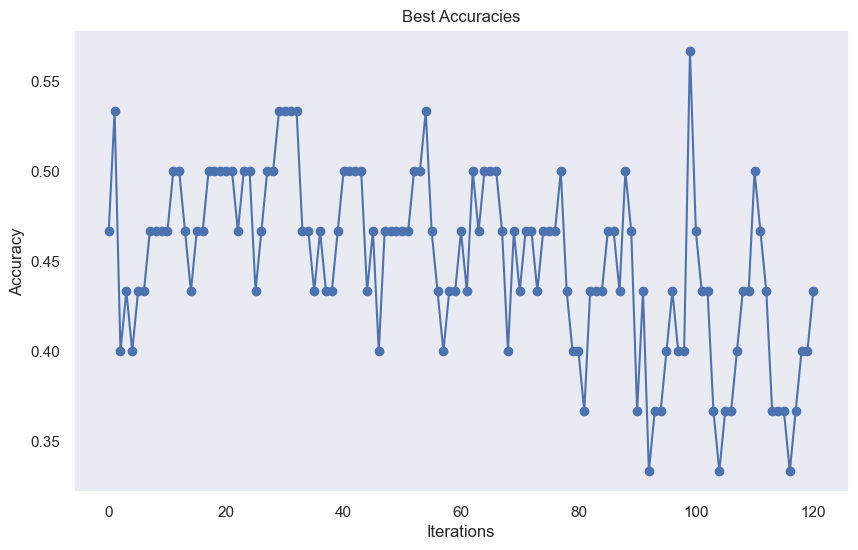

In [8]:
# Find the best index and accuracy
best_index = np.argmax(best_accuracies)
best_accuracy = best_accuracies[best_index]
print(f"Best index: {best_index}, Best accuracy: {best_accuracy}")

# get best mobius
mobius = best_mobius[best_index]
print(f"Best Möbius measure: {[f'{m.X}: {m.mu:.3f}' for m in mobius]}")

# # Evaluate the best capacity
# best_accuracy = FuzzLOO(
#     DS=(data, labels),
#     mu=mobius,
#     sim=S1,
#     choquet_version='d_choquet',
#     p=1,
#     q=1,
#     time_counter=True
# )
# print(f"Best accuracy: {best_accuracy:.4f}")

# Plot the best accuracy
plt.figure(figsize=(10, 6))
plt.plot(best_accuracies, marker='o', linestyle='-', color='b')
plt.title("Best Accuracies")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

## `Iris` Dataset

In [9]:
# Load data 
iris_data = load_iris()
iris = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris['target'] = iris_data.target
data, labels = iris.iloc[:, :-1].values, iris.iloc[:, -1].values
data = batch_norm(np.array(data, dtype=np.float32))
data[:5]

array([[1.        , 0.67346936, 0.24489795, 0.        ],
       [1.        , 0.59574461, 0.25531912, 0.        ],
       [1.        , 0.66666669, 0.24444443, 0.        ],
       [1.        , 0.65909088, 0.29545453, 0.        ],
       [1.        , 0.70833325, 0.24999997, 0.        ]])

In [10]:
# Generate all possible mobius for training
features = list(range(len(data[0])))    # encode features as integers

nb_total = 5

# Input Mobius (10 mobius currently)
lst_mobius = []
for i in range(nb_total):
    mobius = generate_mobius(features, 2)
    mobius.pop(0)
    lst_mobius.append(mobius)

# Mutate all mobius
mutated = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    mutated_mobius = mutate(mobius, mutation_rate=0.8)
    mutated.append(mutated_mobius)

# Add mutated mobius to the list
lst_mobius.extend(mutated)

# Cross over all mobius
crossed_over = []
for i in range(len(lst_mobius)):
    for j in range(i + 1, len(lst_mobius) // 2):
        crossed = crossover(lst_mobius[np.random.randint(len(lst_mobius))], lst_mobius[np.random.randint(len(lst_mobius))])
        crossed_over.append(crossed)

# Add crossed over mobius to the list
lst_mobius.extend(crossed_over)
print(f"Total number of Möbius measures: {len(lst_mobius)}")

# Convert all Möbius measures to capacities
capacities_list = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    capacity = mobius_to_capacity(mobius, features)
    capacities_list.append(capacity)    
print('Test Möbius measures completed!')
print(f"Total number of capacities: {len(capacities_list)}")

Total number of Möbius measures: 20
Test Möbius measures completed!
Total number of capacities: 20


### Test on Mobïus

In [11]:
# Define hyperparameters
p = np.arange(0.25, 3, 0.25)  # p values for Choquet integral
q = np.arange(0.25, 3, 0.25)  # q values for Choquet integral
sim = S2  # similarity measures
choquet_version = 'linear'
verbose = False 
eval_type = 'crossval'  # evaluation type
sim_agent = 'mobius'  # similarity agent for d_Choquet

# Define training loop
best_indexes = []
best_accuracies = []
best_mobius = []
print("Starting training loop...")
start_time = time.time()
i = 0
for p_val in p:
    for q_val in q:
        i += 1
        if i % 10 == 0:
            print(f"Progress: {i}/{len(p) * len(q)}")
        FF_res = fitness_function(
            capacities_list=lst_mobius,
            DS=(data, labels),
            sim=sim,
            choquet_version=choquet_version,
            p=p_val,
            q=q_val,
            time_counter=False,
            verbose=verbose,
            eval_type=eval_type,
            sim_agent=sim_agent
        )
        best_indexes.append(np.argmin(FF_res))
        best_accuracies.append(-FF_res[np.argmin(FF_res)])
        best_mobius.append(lst_mobius[np.argmin(FF_res)])

end_time = time.time()
print(f"Training loop completed in {end_time - start_time:.2f} seconds.")

Starting training loop...
Progress: 10/121
Progress: 20/121
Progress: 30/121
Progress: 40/121
Progress: 50/121
Progress: 60/121
Progress: 70/121
Progress: 80/121
Progress: 90/121
Progress: 100/121
Progress: 110/121
Progress: 120/121
Training loop completed in 1162.32 seconds.


Best index: 3, Best accuracy: 0.8333333333333334
Best Möbius measure: ['[0]: 0.790', '[1]: 0.606', '[2]: 0.926', '[3]: 0.651', '[0, 1]: 0.915', '[0, 2]: 0.850', '[0, 3]: 0.449', '[1, 2]: 0.095', '[1, 3]: 0.371', '[2, 3]: 0.669']

Best Capacity:
Capacity of [] is 0.000
Capacity of [0] is 0.125
Capacity of [1] is 0.096
Capacity of [2] is 0.146
Capacity of [3] is 0.103
Capacity of [0, 1] is 0.366
Capacity of [0, 2] is 0.406
Capacity of [0, 3] is 0.299
Capacity of [1, 2] is 0.257
Capacity of [1, 3] is 0.257
Capacity of [2, 3] is 0.355
Capacity of [0, 1, 2] is 0.662
Capacity of [0, 1, 3] is 0.598
Capacity of [0, 2, 3] is 0.686
Capacity of [1, 2, 3] is 0.525
Capacity of [0, 1, 2, 3] is 1.000
Result in 1.5516 seconds.
Best accuracy: 0.6667


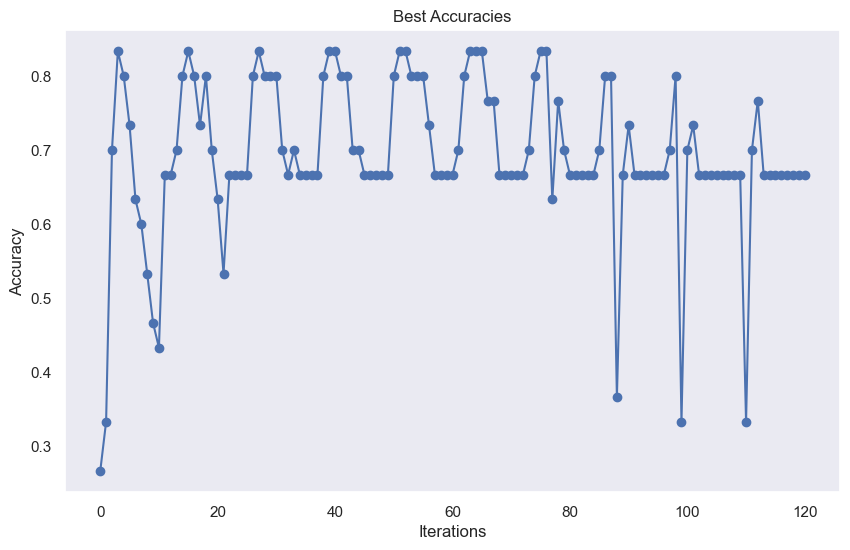

In [12]:
# Find the best index and accuracy
best_index = np.argmax(best_accuracies)
best_accuracy = best_accuracies[best_index]
print(f"Best index: {best_index}, Best accuracy: {best_accuracy}")

# get best mobius
mobius = best_mobius[best_index]
print(f"Best Möbius measure: {[f'{m.X}: {m.mu:.3f}' for m in mobius]}")

# Convert mobius to capacity
best_capacity = mobius_to_capacity(mobius, features)
print("\nBest Capacity:")
for c in best_capacity:
    print(f"Capacity of {c.X} is {c.mu:.3f}")

# Evaluate the best capacity
best_accuracy = FuzzLOO(
    DS=(data, labels),
    mu=best_capacity,
    sim=S1,
    choquet_version='d_choquet',
    p=1,
    q=1,
    time_counter=True
)
print(f"Best accuracy: {best_accuracy:.4f}")

# Plot the best accuracy
plt.figure(figsize=(10, 6))
plt.plot(best_accuracies, marker='o', linestyle='-', color='b')
plt.title("Best Accuracies")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

### Test on Capacities

In [13]:
# Define hyperparameters
p = np.arange(0.25, 3, 0.25)  # p values for Choquet integral
q = np.arange(0.25, 3, 0.25)  # q values for Choquet integral
sim = S2  # similarity measures
choquet_version = 'd_choquet'
verbose = False 
eval_type = 'crossval'  # evaluation type
sim_agent = 'capacity'  # similarity agent for d_Choquet

# Define training loop
best_indexes = []
best_accuracies = []
best_mobius = []
print("Starting training loop...")
start_time = time.time()
i = 0
for p_val in p:
    for q_val in q:
        i += 1
        if i % 10 == 0:
            print(f"Progress: {i}/{len(p) * len(q)}")
        FF_res = fitness_function(
            capacities_list=lst_mobius,
            DS=(data, labels),
            sim=sim,
            choquet_version=choquet_version,
            p=p_val,
            q=q_val,
            time_counter=False,
            verbose=verbose,
            eval_type=eval_type,
            sim_agent=sim_agent
        )
        best_indexes.append(np.argmin(FF_res))
        best_accuracies.append(-FF_res[np.argmin(FF_res)])
        best_mobius.append(lst_mobius[np.argmin(FF_res)])

end_time = time.time()
print(f"Training loop completed in {end_time - start_time:.2f} seconds.")

Starting training loop...
Progress: 10/121
Progress: 20/121
Progress: 30/121
Progress: 40/121
Progress: 50/121
Progress: 60/121
Progress: 70/121
Progress: 80/121
Progress: 90/121
Progress: 100/121
Progress: 110/121
Progress: 120/121
Training loop completed in 421.28 seconds.


Best index: 1, Best accuracy: 0.6666666666666666
Best Möbius measure: ['[0]: 0.790', '[1]: 0.606', '[2]: 0.926', '[3]: 0.651', '[0, 1]: 0.915', '[0, 2]: 0.850', '[0, 3]: 0.449', '[1, 2]: 0.095', '[1, 3]: 0.371', '[2, 3]: 0.669']


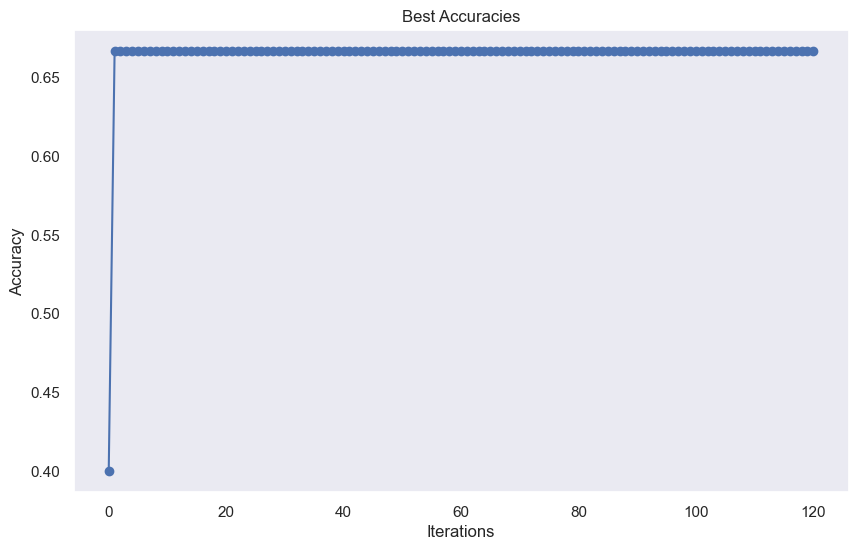

In [14]:
# Find the best index and accuracy
best_index = np.argmax(best_accuracies)
best_accuracy = best_accuracies[best_index]
print(f"Best index: {best_index}, Best accuracy: {best_accuracy}")

# get best mobius
mobius = best_mobius[best_index]
print(f"Best Möbius measure: {[f'{m.X}: {m.mu:.3f}' for m in mobius]}")

# # Evaluate the best capacity
# best_accuracy = FuzzLOO(
#     DS=(data, labels),
#     mu=mobius,
#     sim=S1,
#     choquet_version='d_choquet',
#     p=1,
#     q=1,
#     time_counter=True
# )
# print(f"Best accuracy: {best_accuracy:.4f}")

# Plot the best accuracy
plt.figure(figsize=(10, 6))
plt.plot(best_accuracies, marker='o', linestyle='-', color='b')
plt.title("Best Accuracies")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.grid()
plt.show()